In [23]:
directory = '/storage/experiments/2024/01_AIRDOS04_PRG-GVA_GVA-PRG' # Directory with data 

FIRST_CHANNEL = 8 # a column of the 1st channel without noise
ZERO_CHANNEL = 4 # a column of the channel with maximal noise
CH_WIDTH = 0.0078 # [MeV]

In [24]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import matplotlib
import re

In [46]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

df=pd.DataFrame()

sn = '0'
files = sorted(glob.iglob(directory + '/*.TXT'), key=numericalSort)
for file in files:
    print(file)
    l=[]
    l.extend(range(0,1028))
    f = pd.read_csv(file, sep=',', header=None, names=l, comment='*', low_memory=False)
    try:
        sn = f.loc[f[0]=='$DOS'].iloc[0,6]
        print("S.N.: ", sn)
    except:
        pass
    df = pd.concat([df,f])

df = df.reset_index(drop=True)
print('All files was readed.')

/storage/experiments/2024/01_AIRDOS04_PRG-GVA_GVA-PRG/0.TXT
S.N.:  ffffffffffffffffffffffffffffffff
/storage/experiments/2024/01_AIRDOS04_PRG-GVA_GVA-PRG/1.TXT
S.N.:  ffffffffffffffffffffffffffffffff
/storage/experiments/2024/01_AIRDOS04_PRG-GVA_GVA-PRG/2.TXT
/storage/experiments/2024/01_AIRDOS04_PRG-GVA_GVA-PRG/3.TXT
S.N.:  ffffffffffffffffffffffffffffffff
/storage/experiments/2024/01_AIRDOS04_PRG-GVA_GVA-PRG/4.TXT
S.N.:  ffffffffffffffffffffffffffffffff
/storage/experiments/2024/01_AIRDOS04_PRG-GVA_GVA-PRG/5.TXT
/storage/experiments/2024/01_AIRDOS04_PRG-GVA_GVA-PRG/6.TXT
/storage/experiments/2024/01_AIRDOS04_PRG-GVA_GVA-PRG/7.TXT
All files was readed.


In [47]:
run = 0
df['run'] = np.nan

try:
    for x in df.loc[df[0]=='$DOS'].index:
        df.loc[x,'run'] = run
        run += 1
except:
    pass
df['run'].fillna(method="ffill", inplace=True)
df = df.loc[df[0]=='$HIST'].copy()


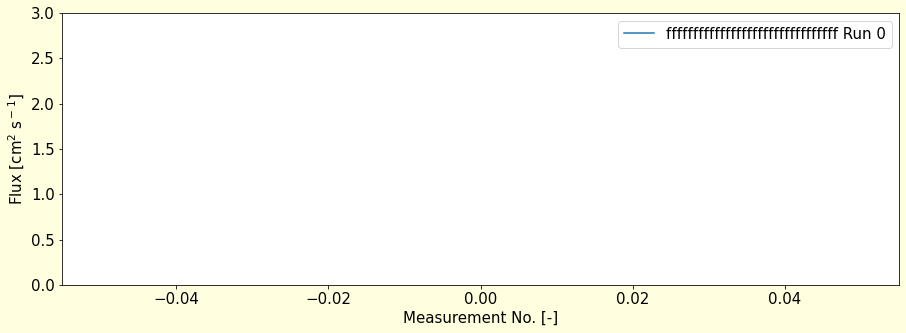

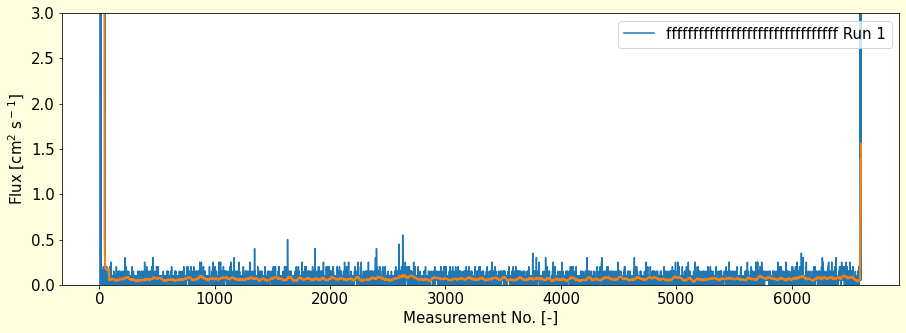

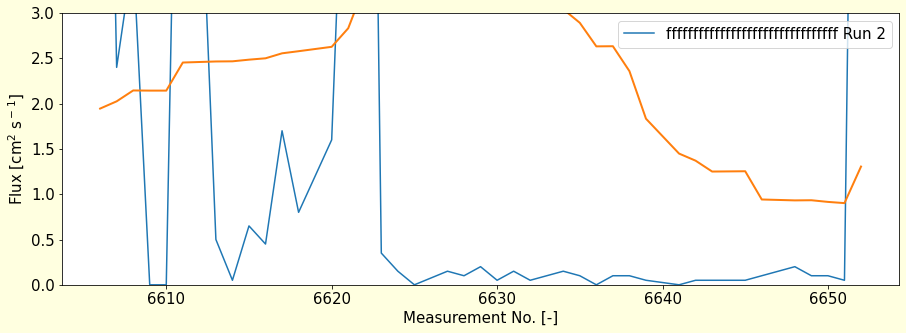

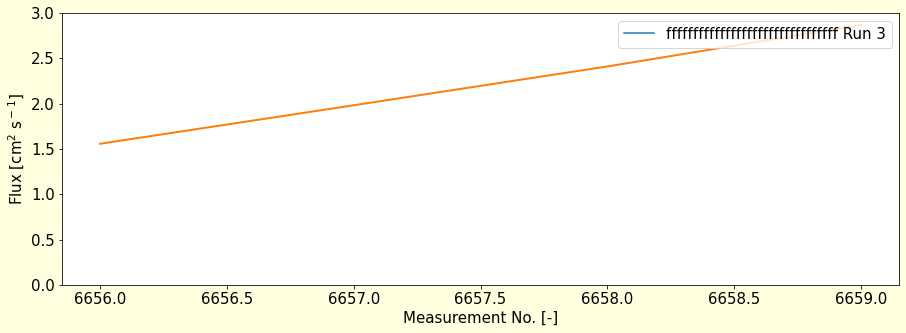

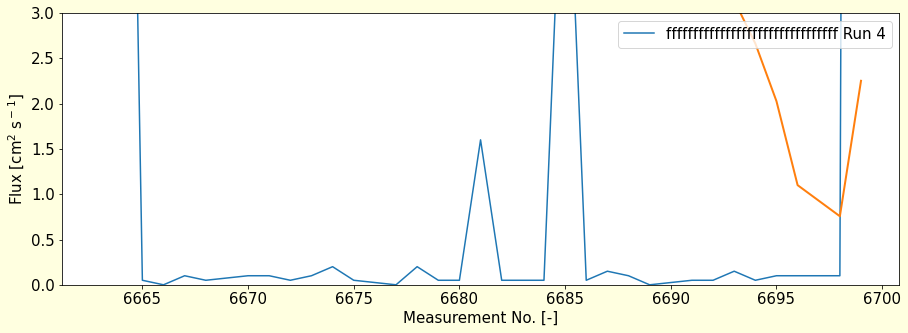

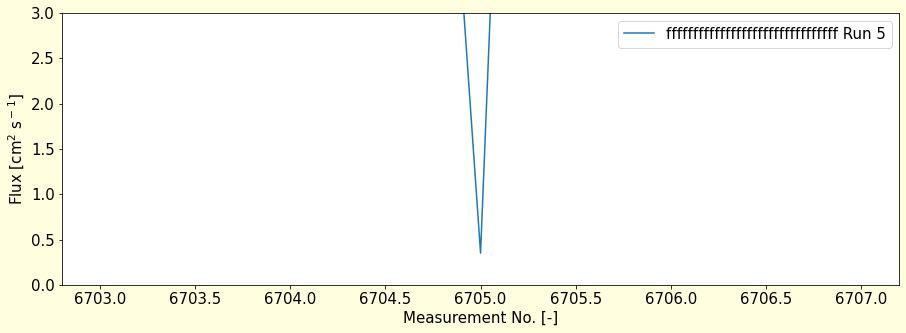

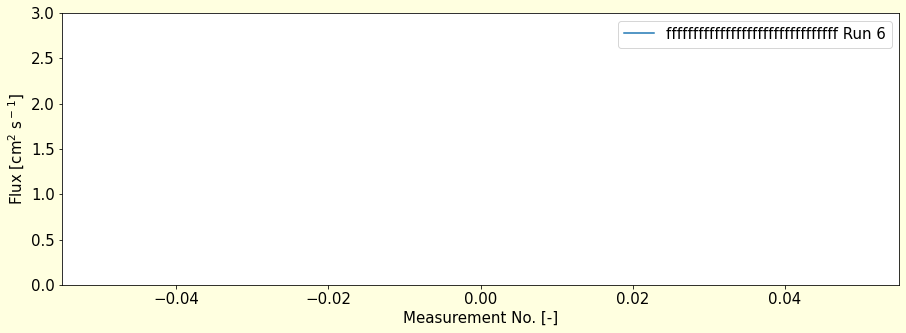

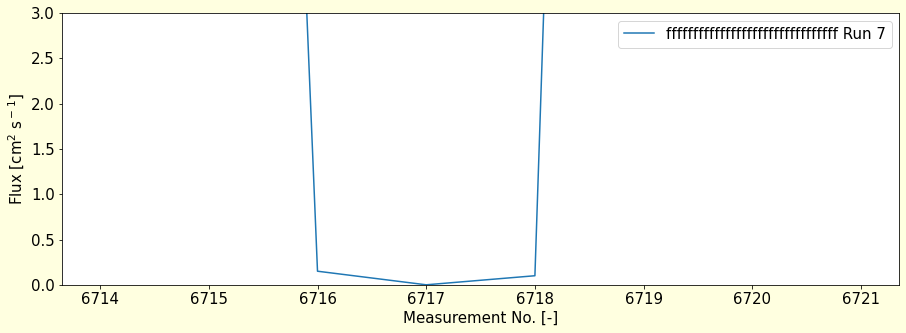

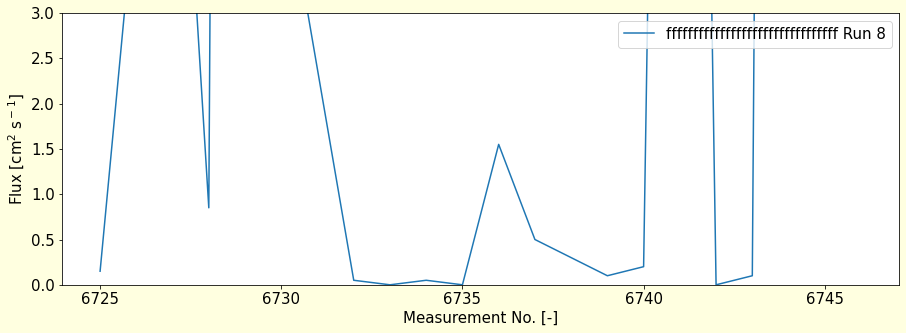

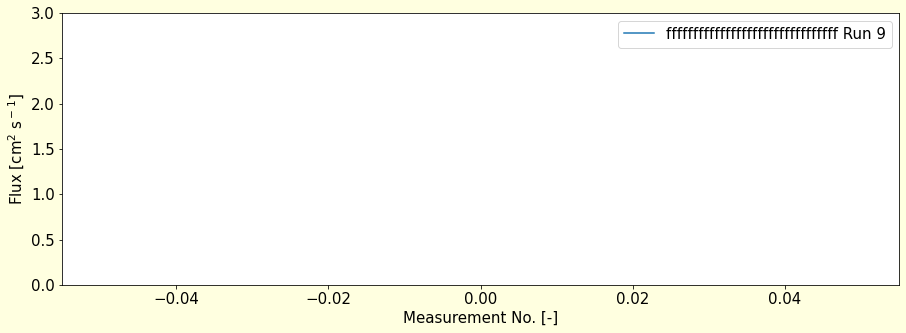

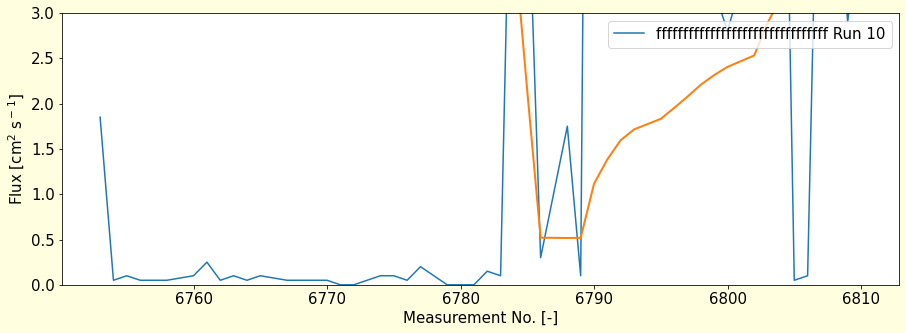

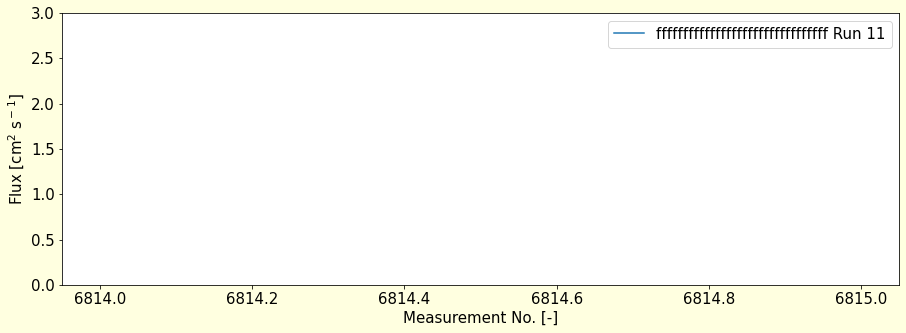

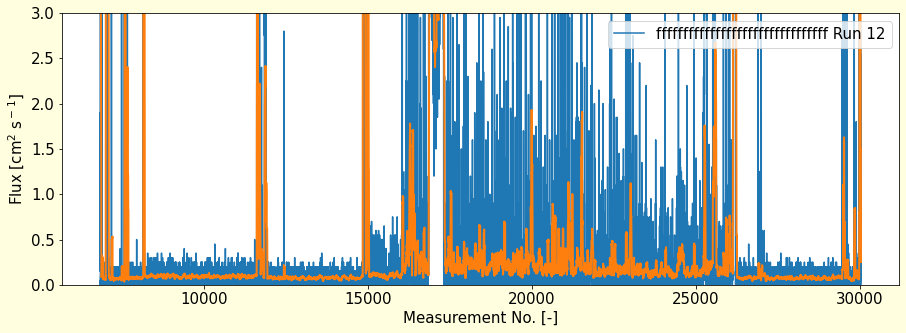

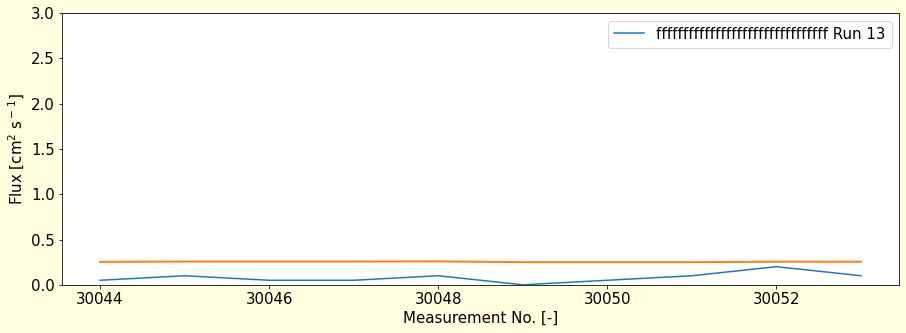

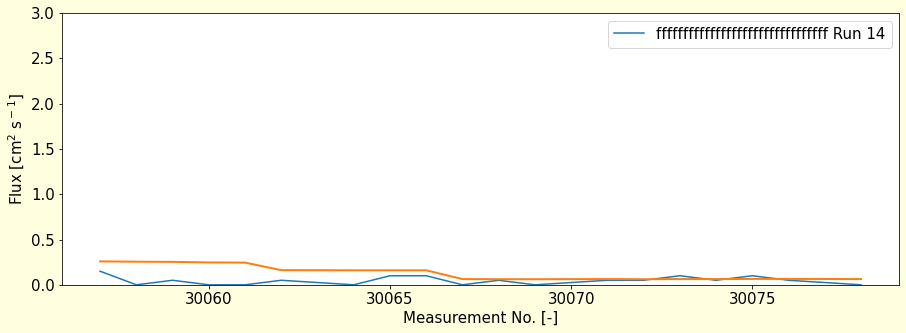

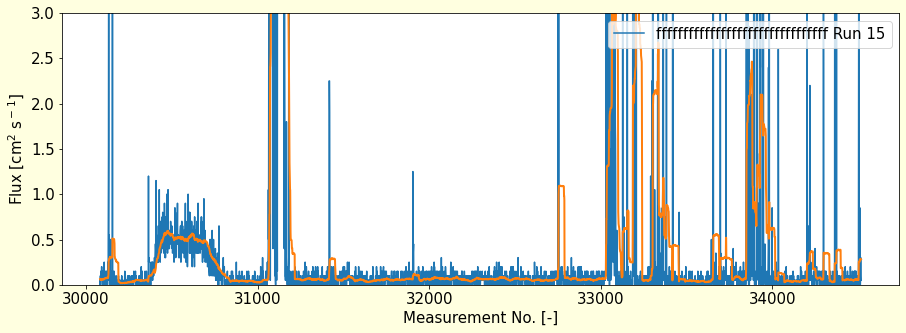

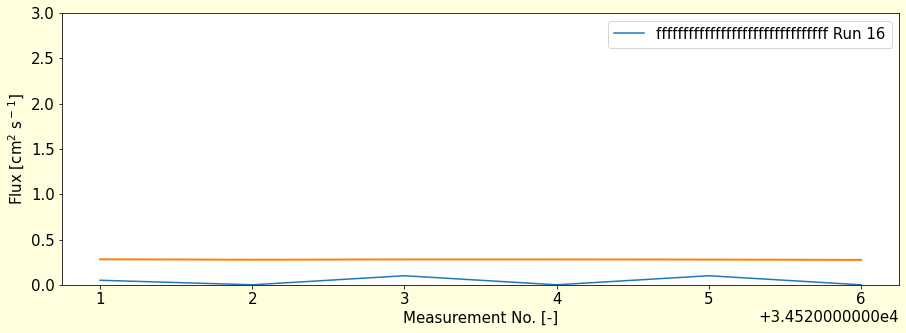

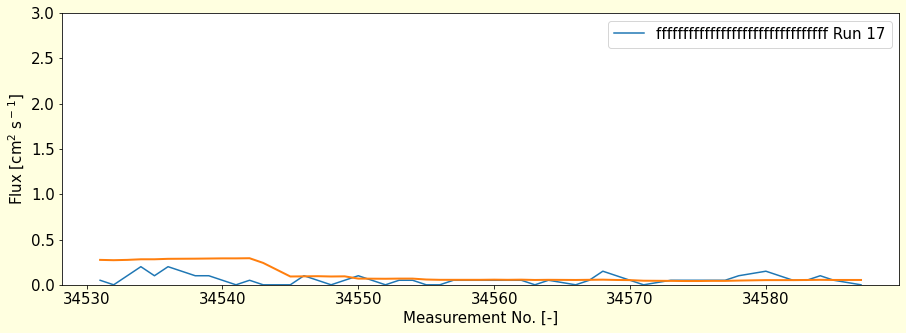

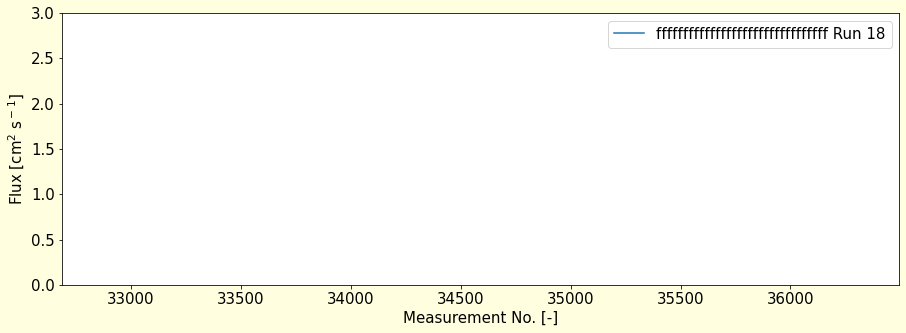

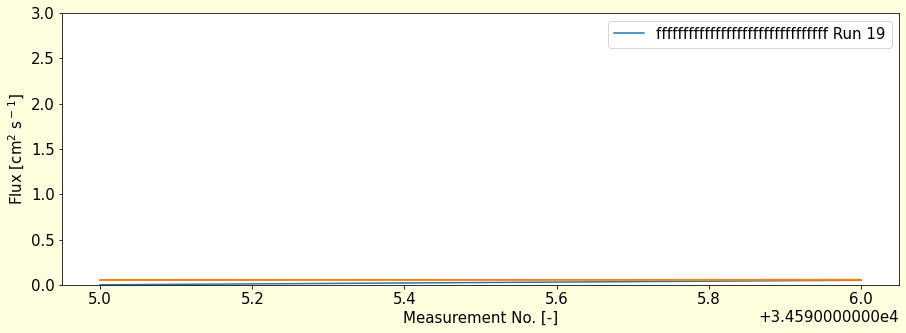

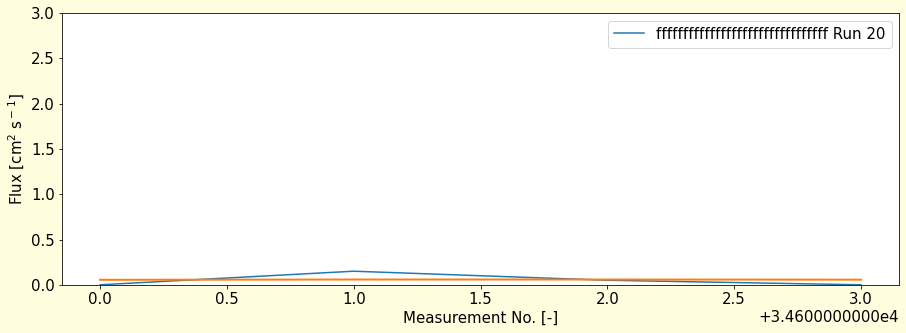

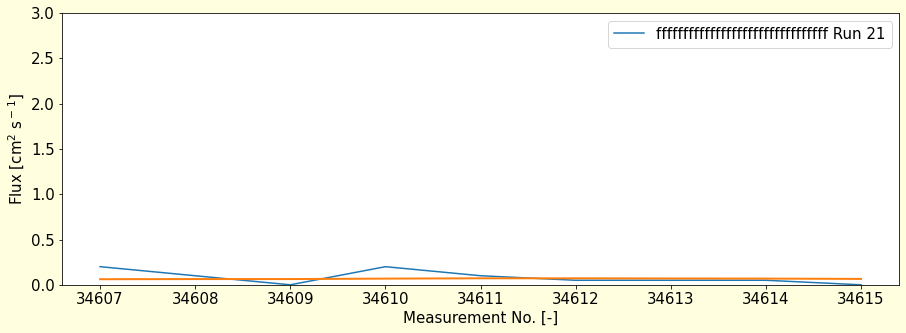

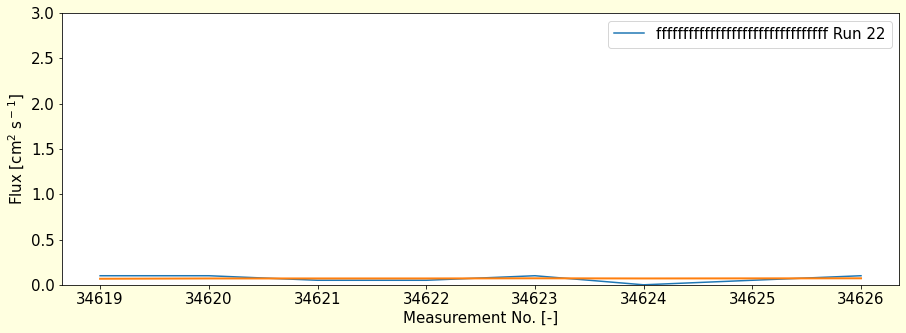

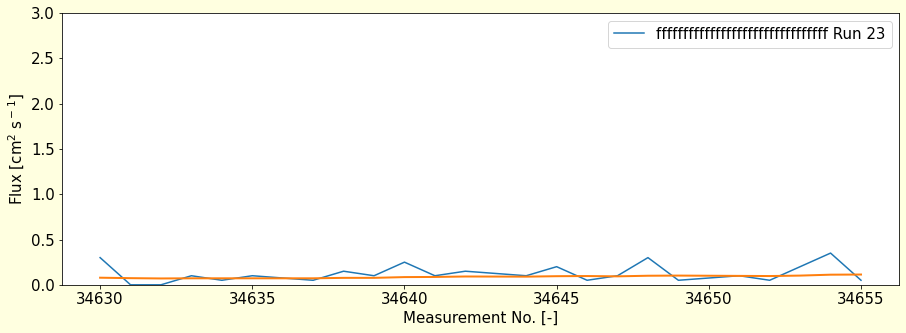

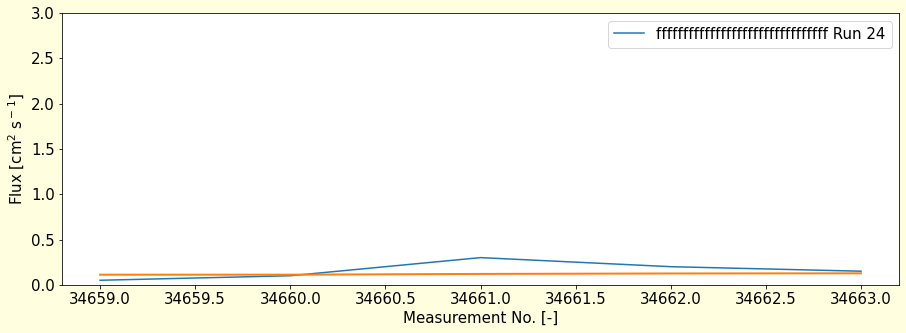

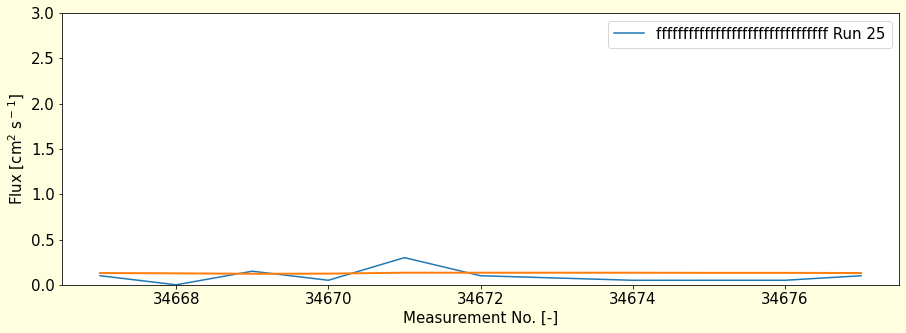

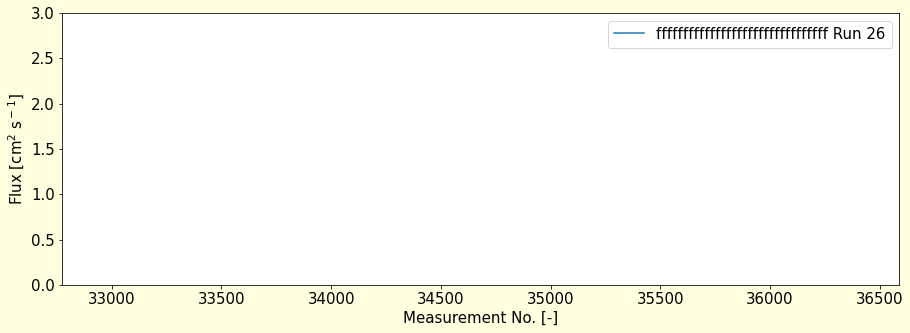

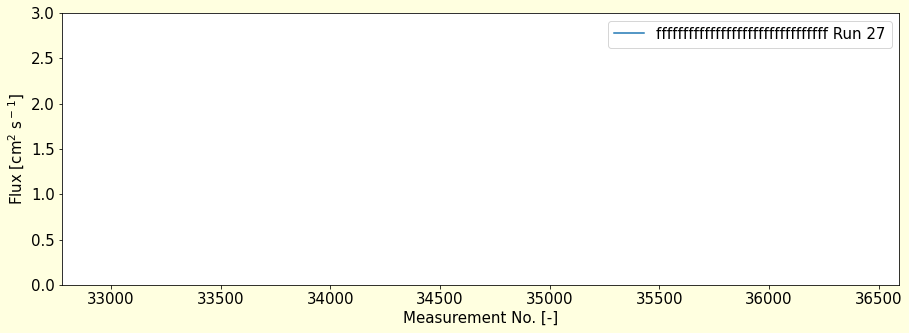

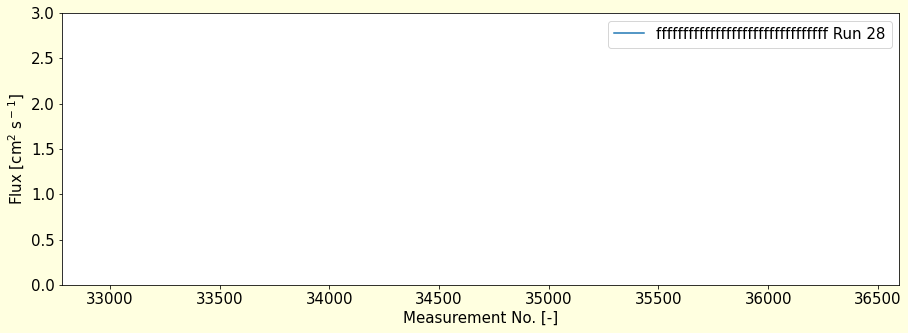

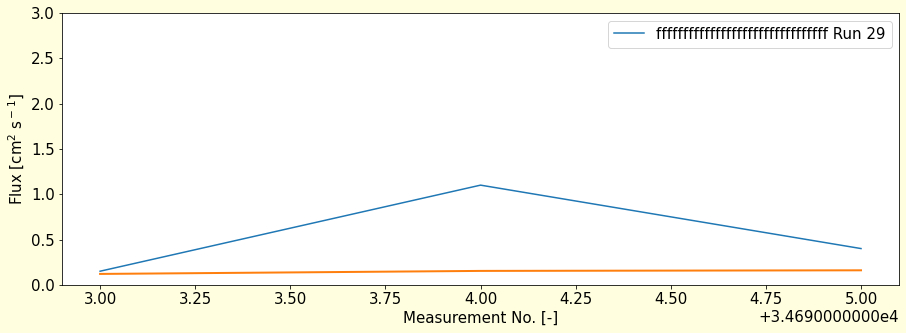

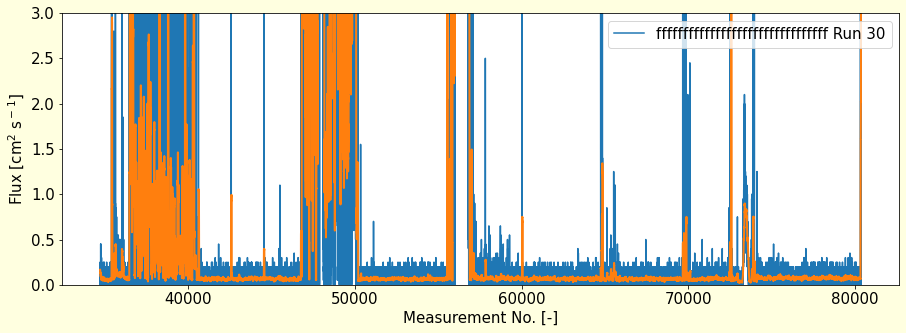

In [50]:
df['sum'] = df.iloc[:,FIRST_CHANNEL:1028].sum(axis=1)
df['mean'] = df['sum'].rolling(30).mean()

matplotlib.rcParams.update({'font.size': 15})

for r in range(0,run):
    plt.figure(figsize=(15,5), facecolor='lightyellow')
    plt.plot(df.loc[df['run']==r]['sum']/20, label=sn+' Run '+str(r))
    plt.plot(df.loc[df['run']==r]['mean']/20, lw=2)
    plt.ylim(0,3)
    plt.xlabel('Measurement No. [-]')
    plt.ylabel('Flux [cm$^2$ s$^-$$^1$]')
    plt.legend(loc=1)
    plt.show()


0.039 0.0078


/tmp/ipykernel_866/1220617035.py:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


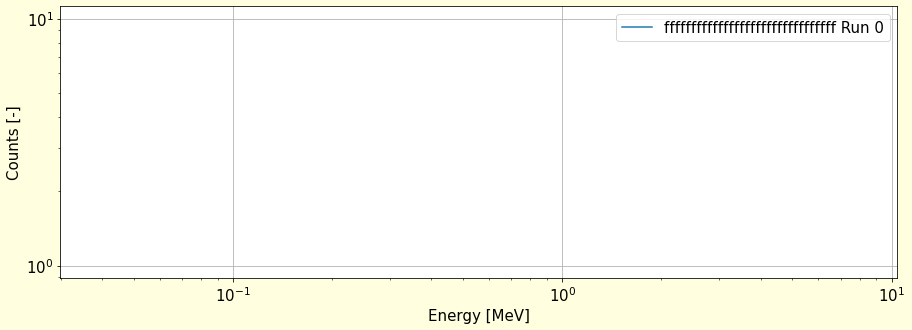

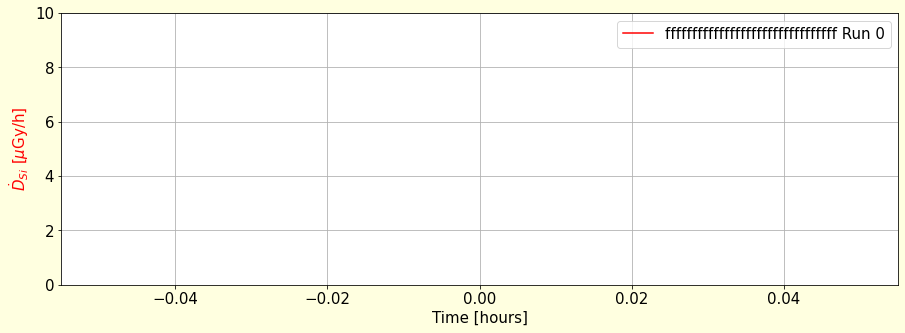

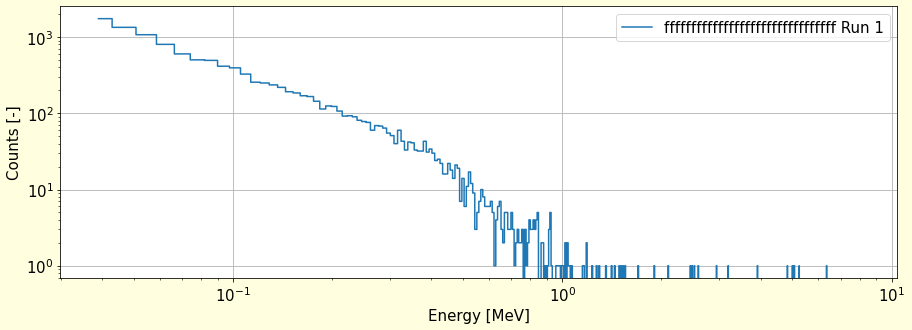

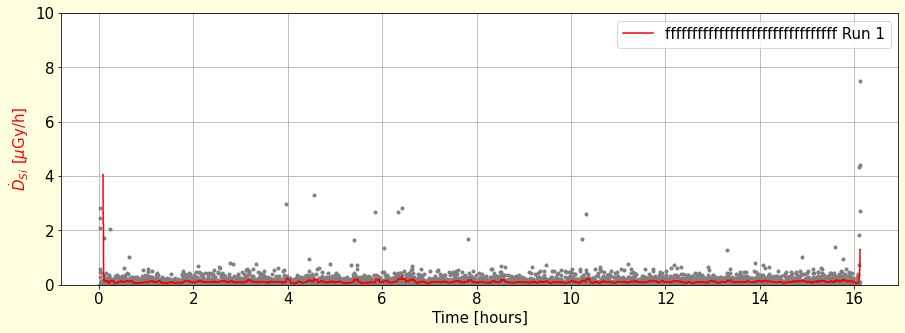

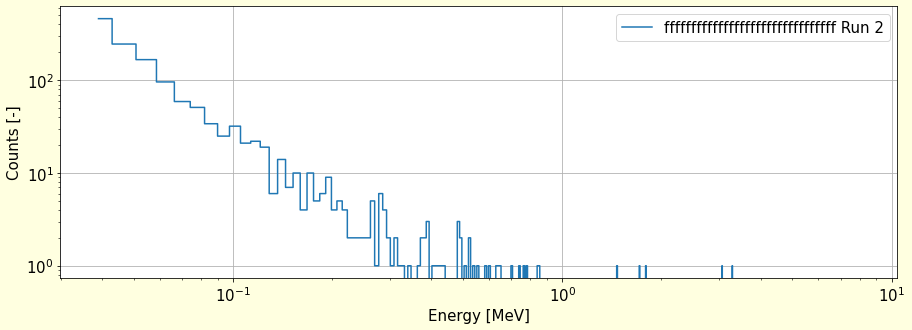

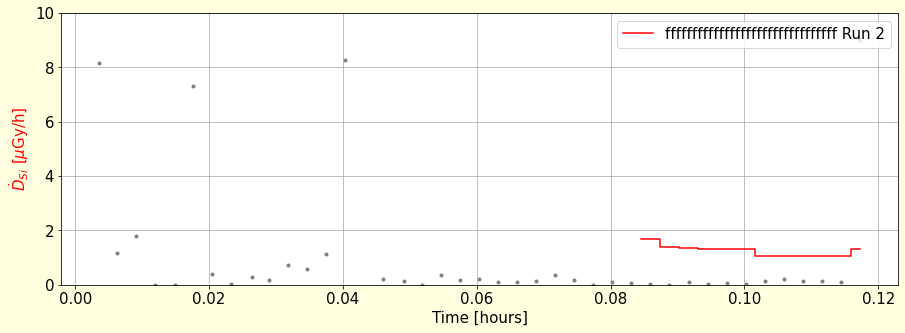

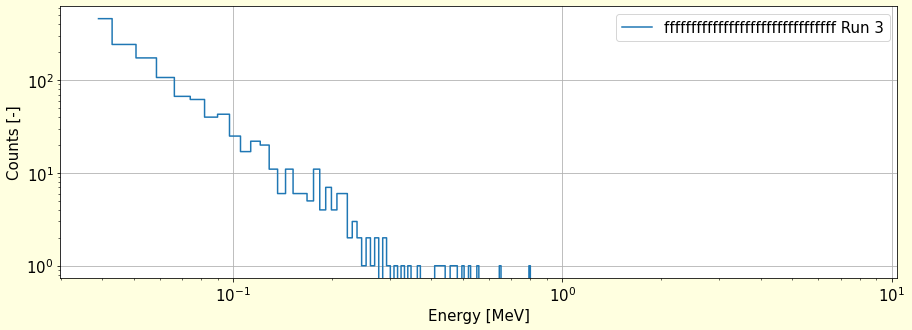

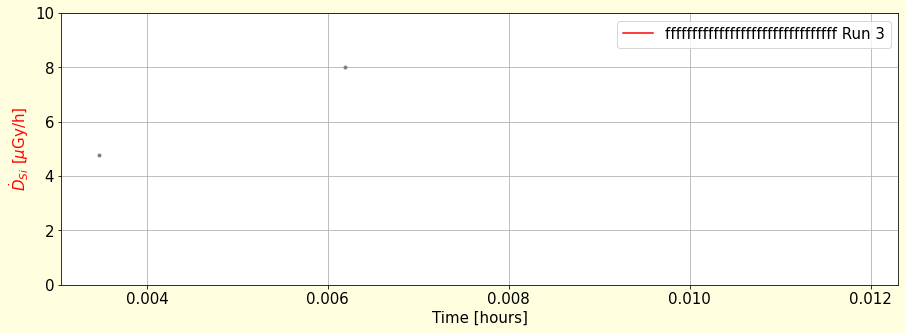

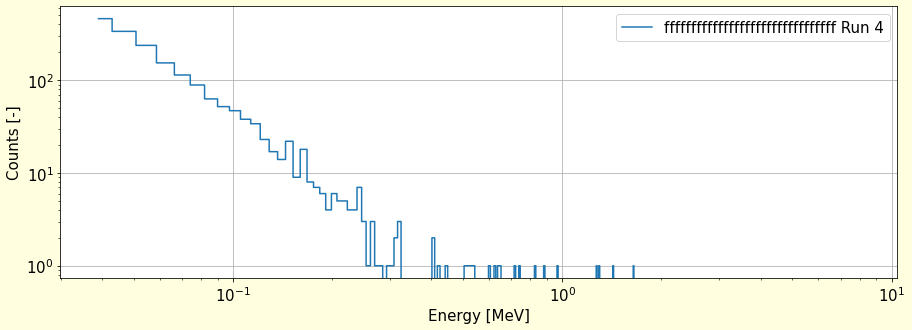

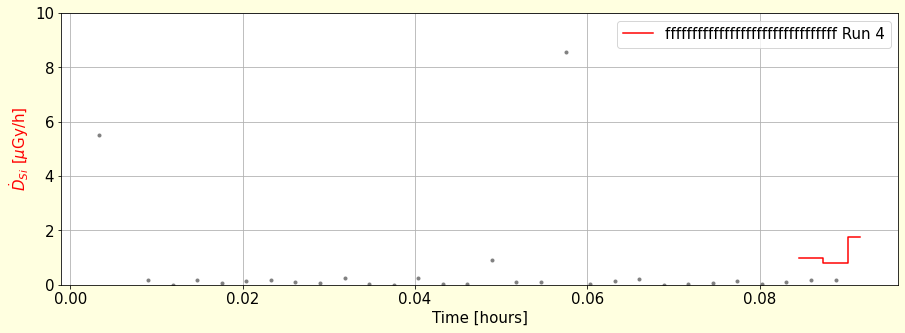

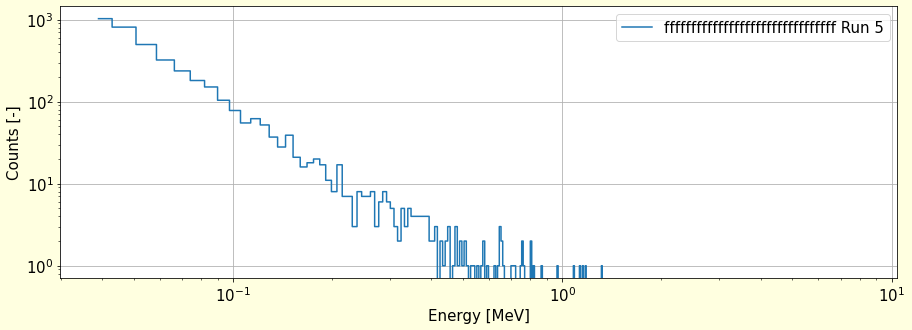

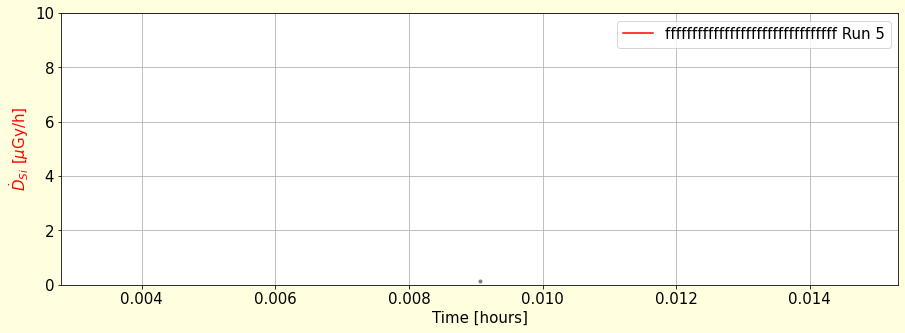

/tmp/ipykernel_866/1220617035.py:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


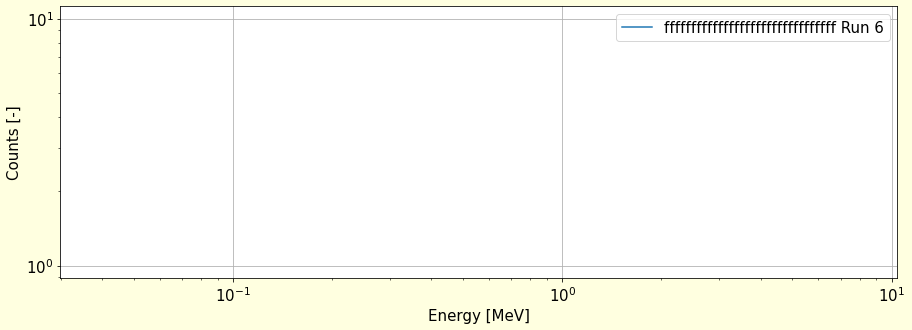

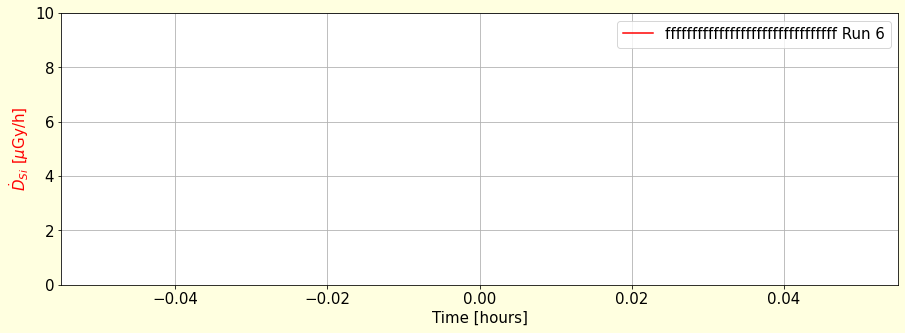

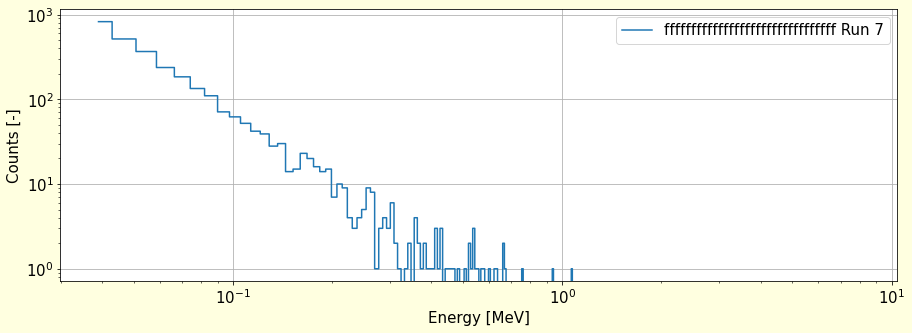

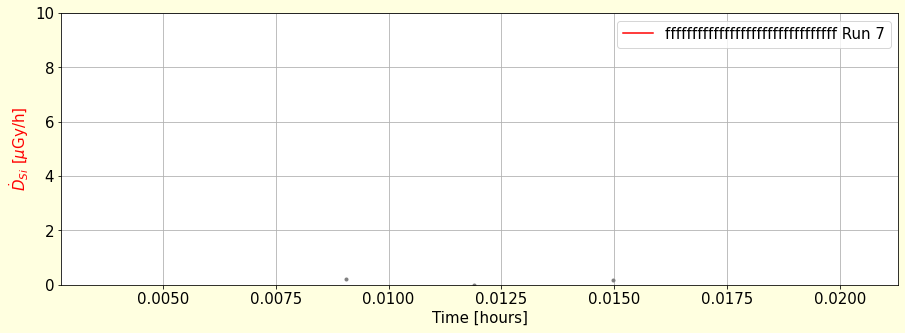

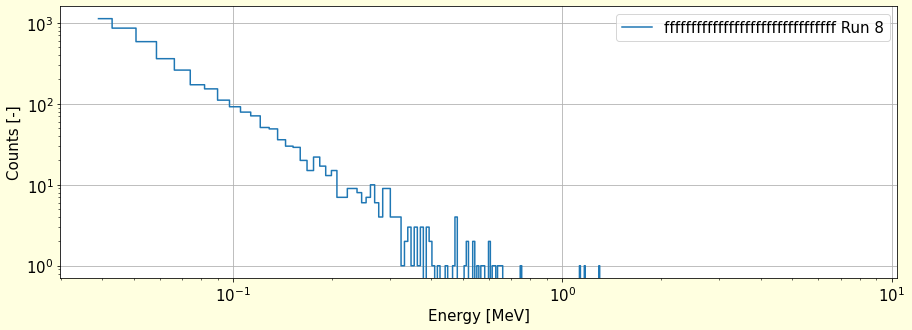

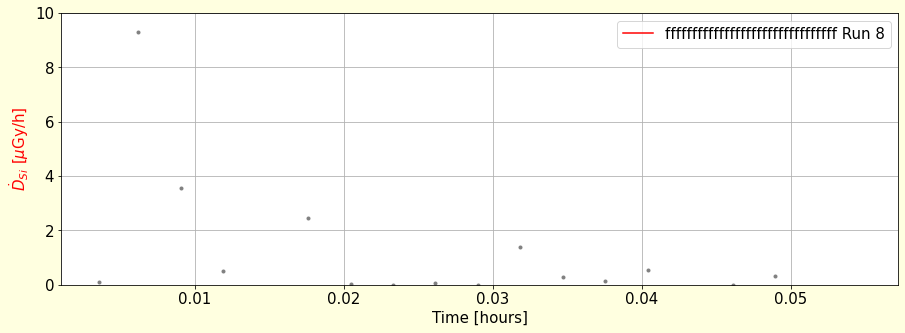

/tmp/ipykernel_866/1220617035.py:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


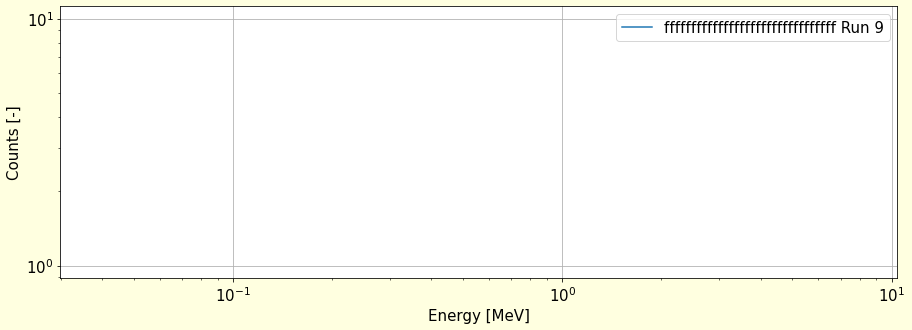

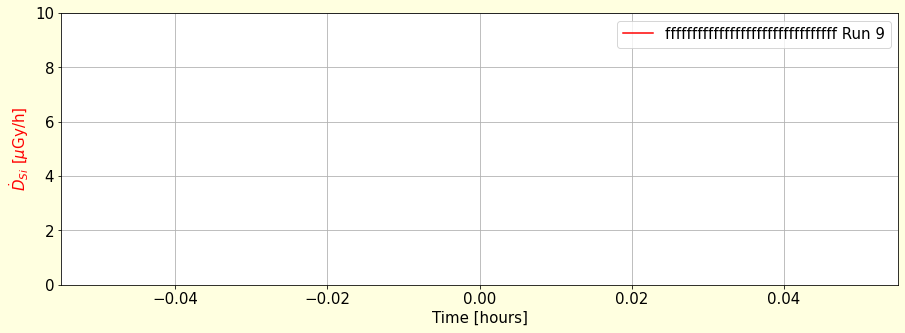

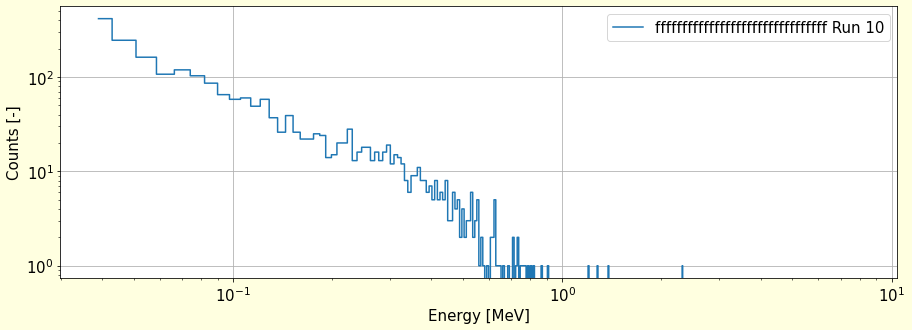

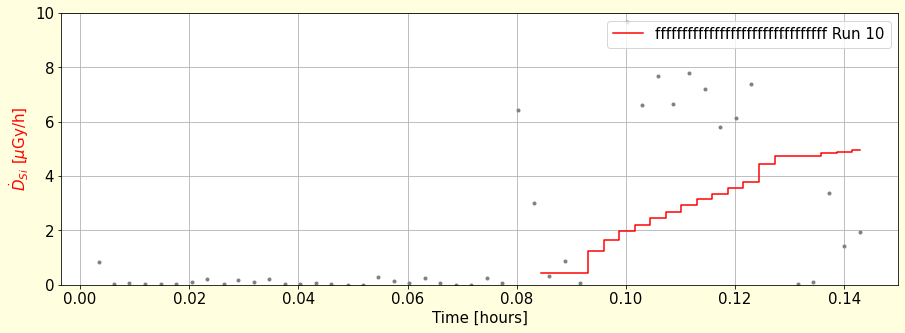

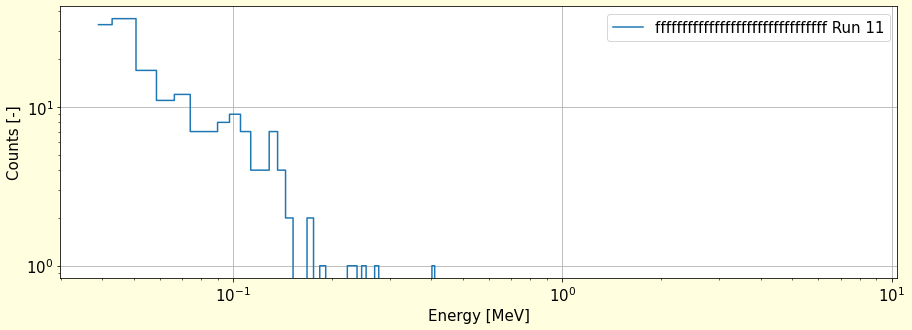

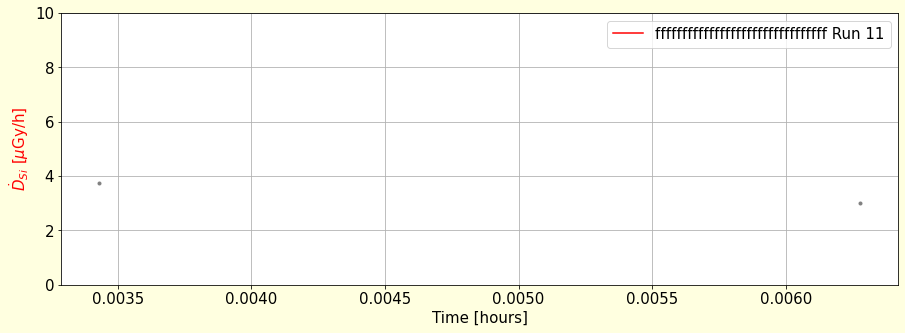

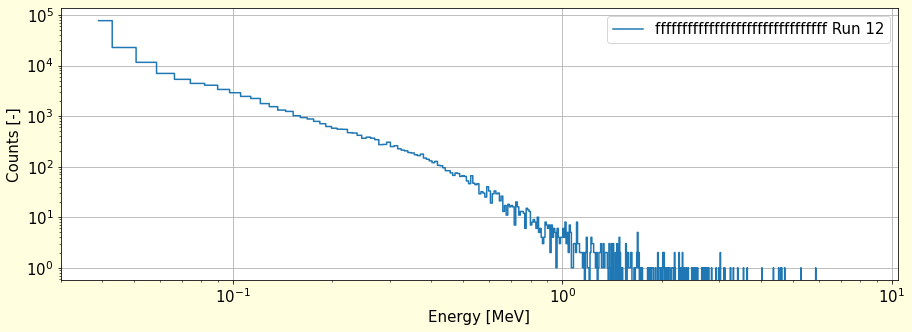

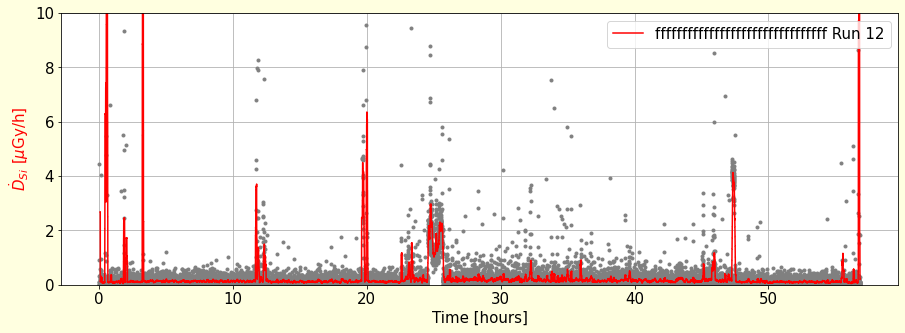

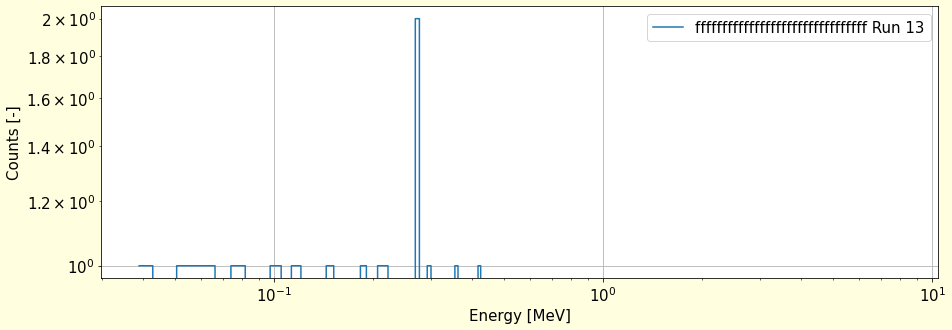

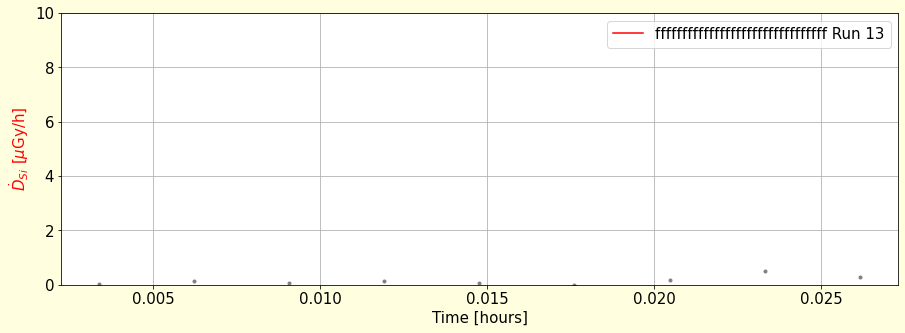

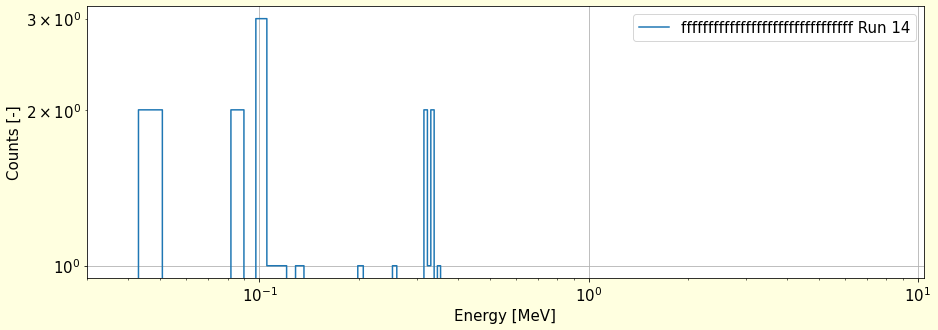

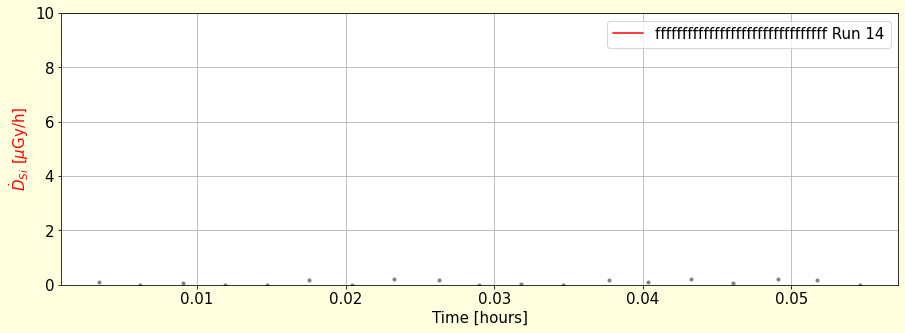

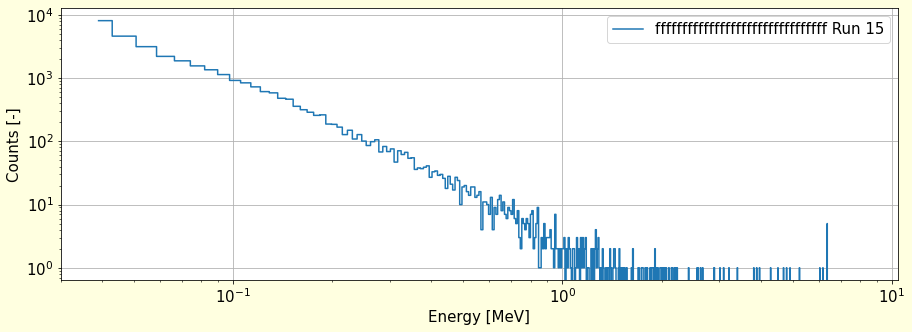

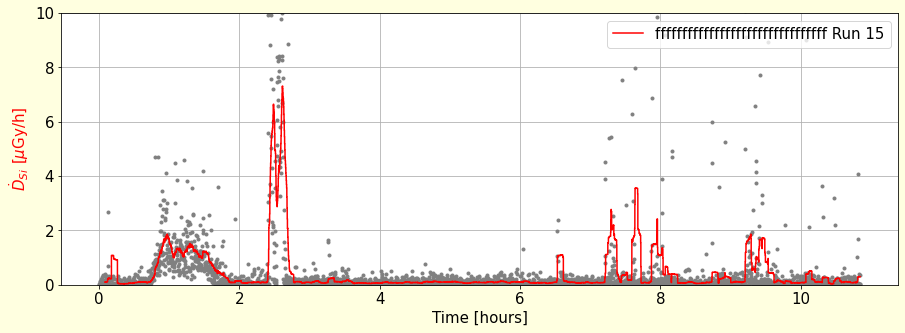

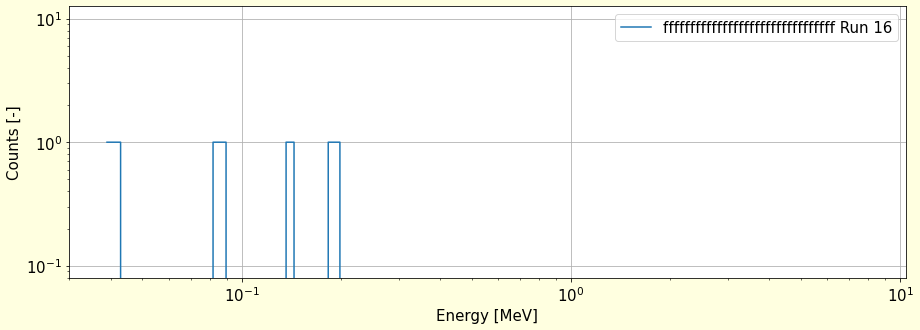

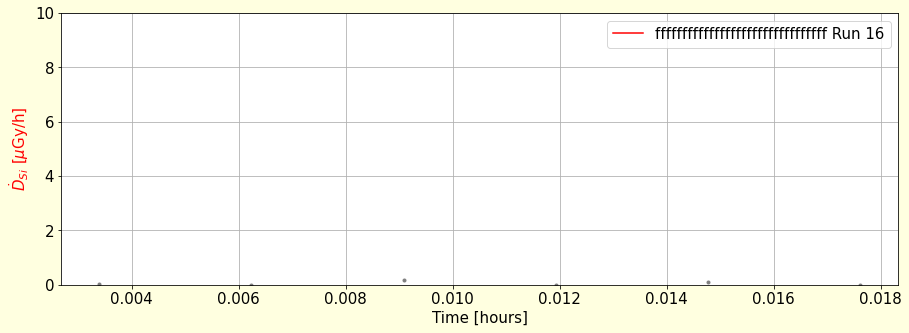

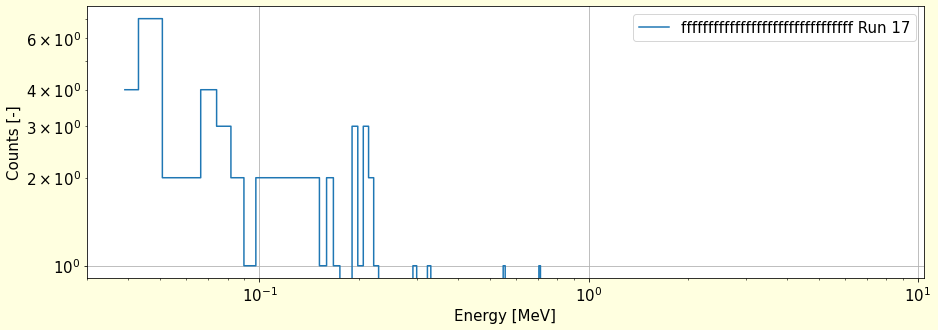

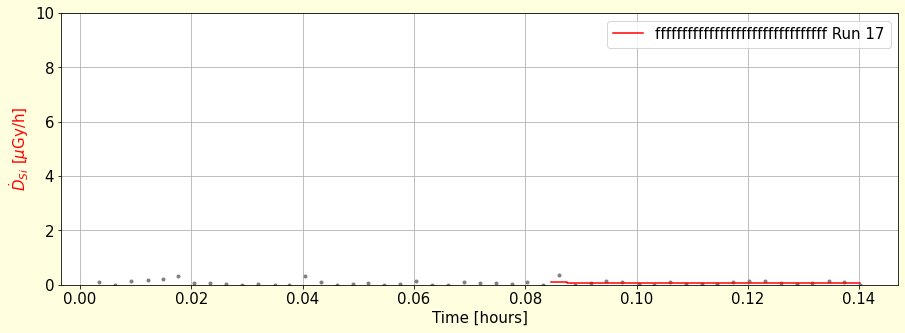

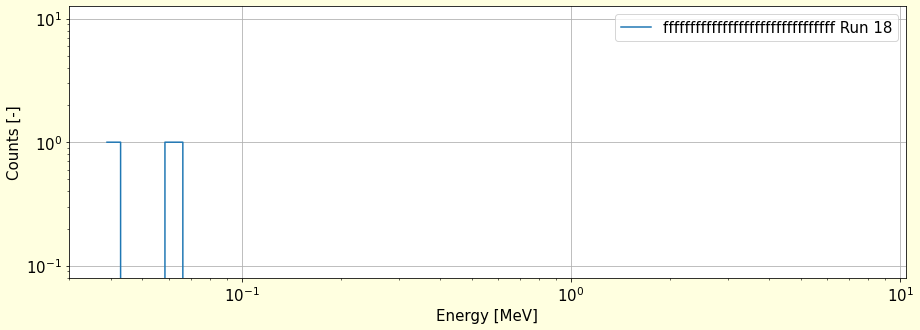

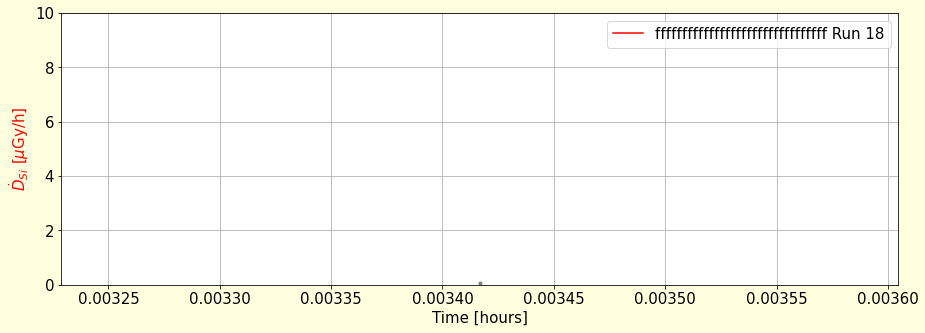

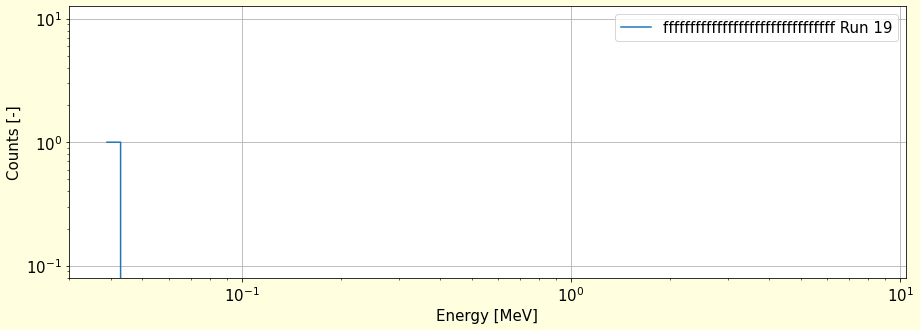

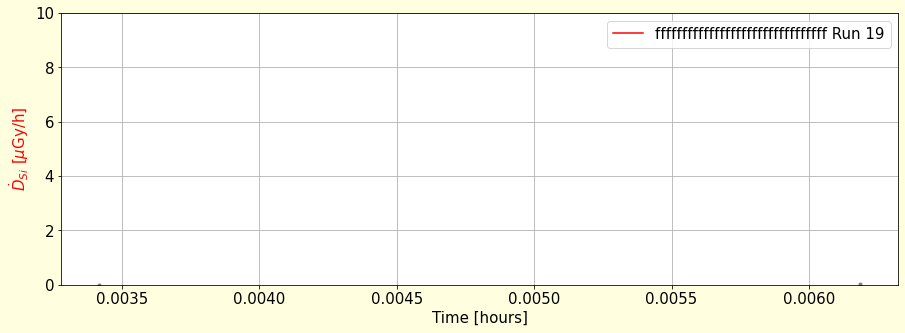

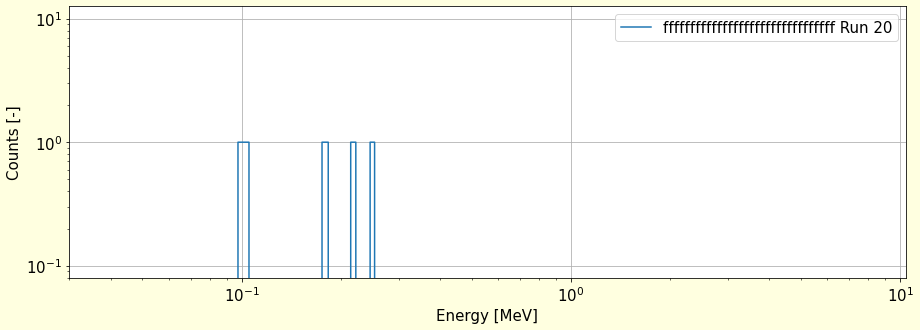

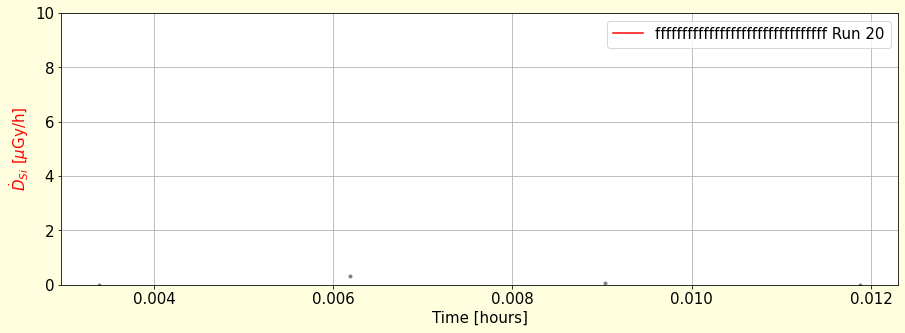

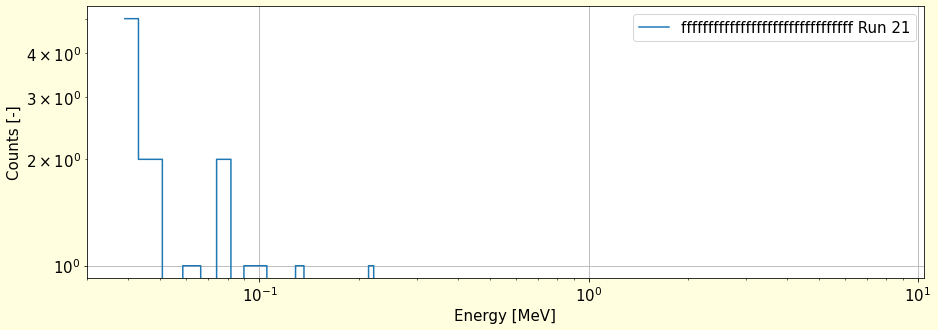

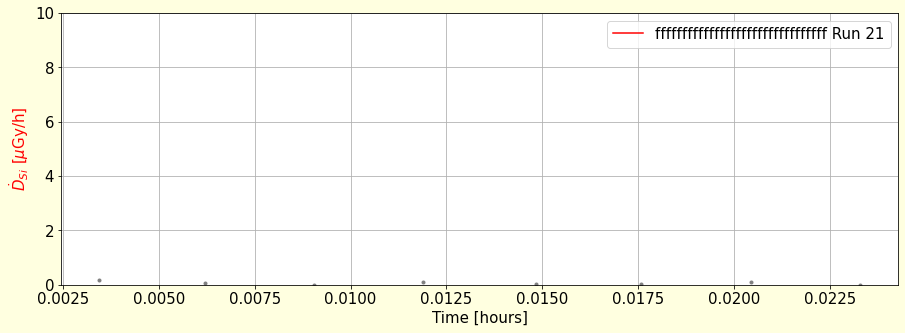

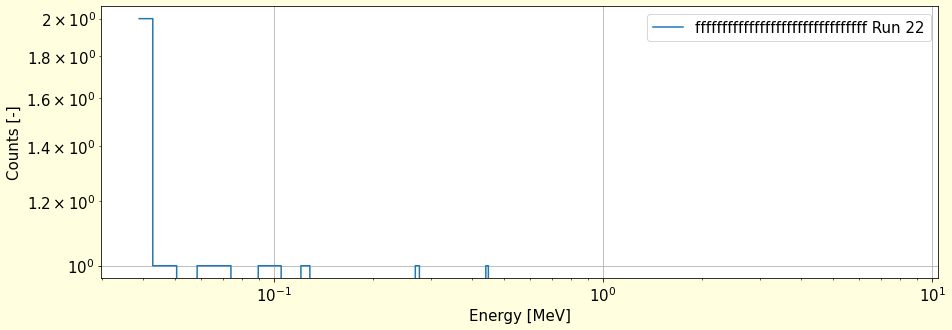

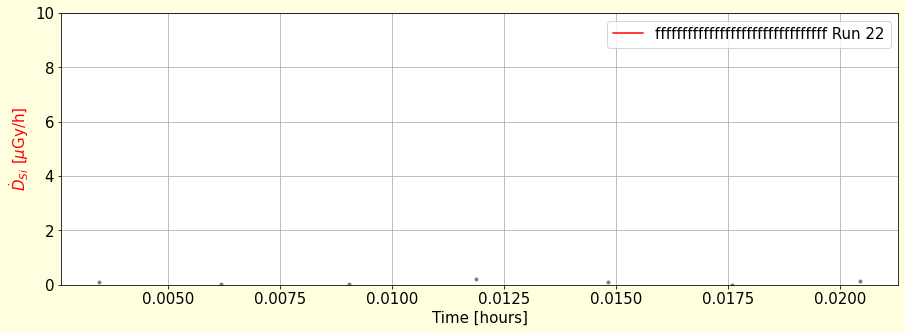

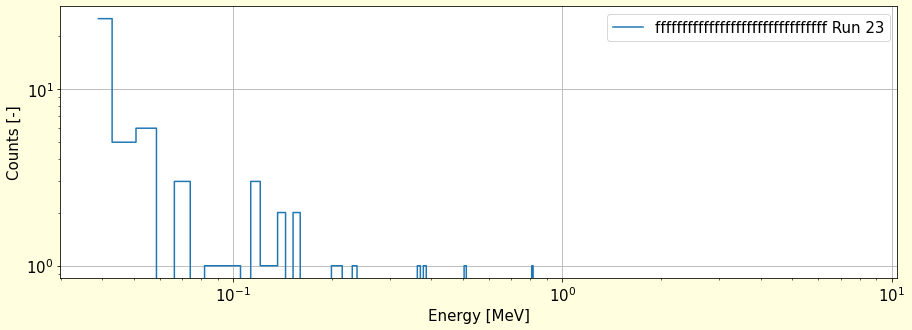

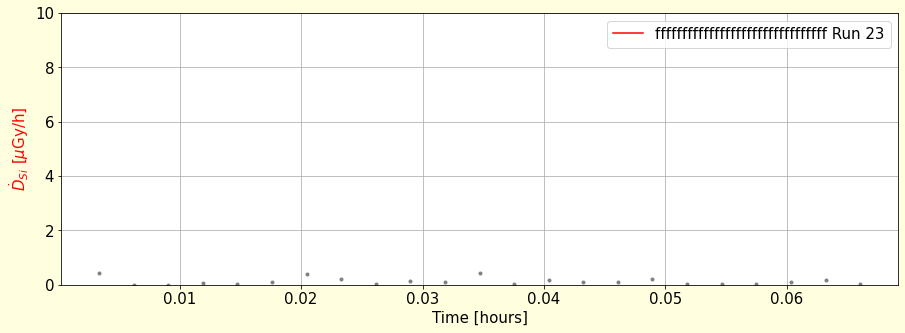

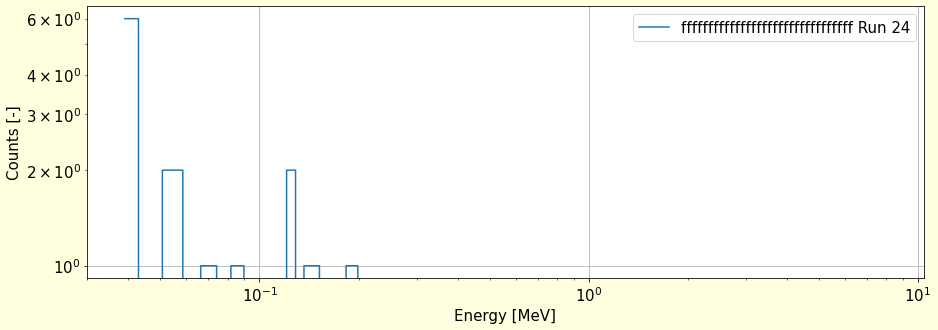

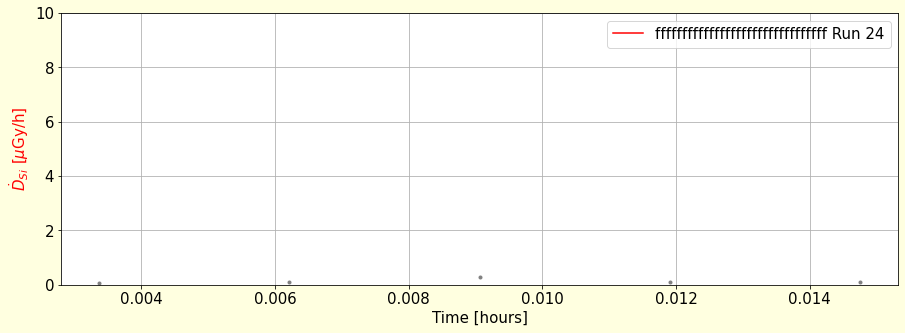

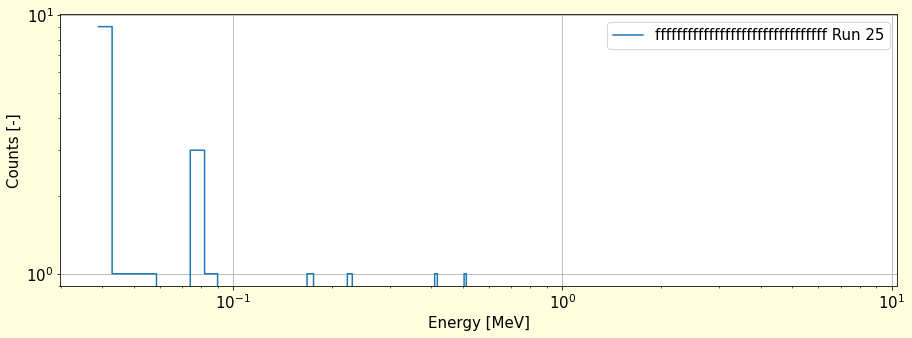

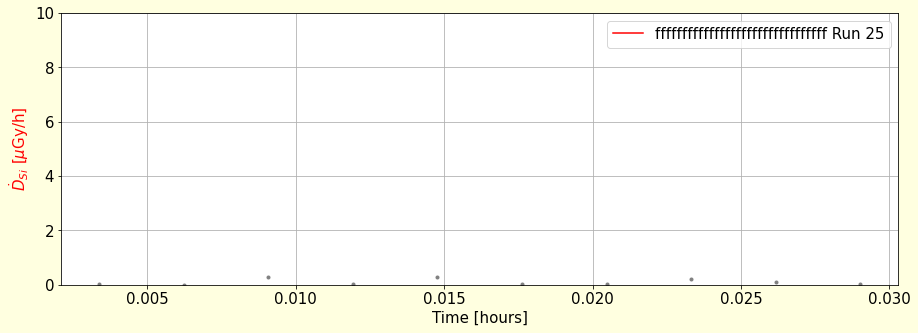

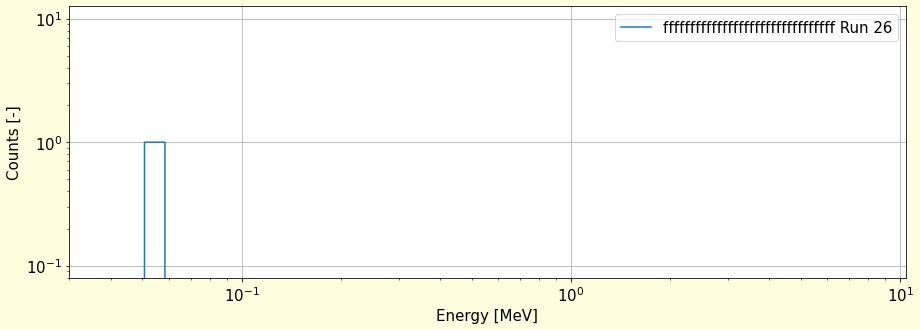

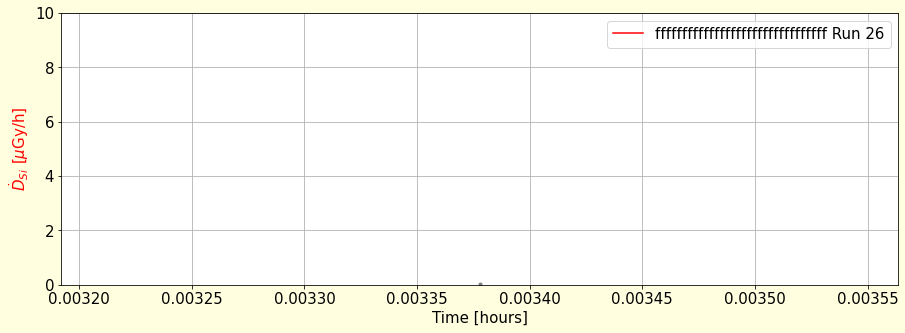

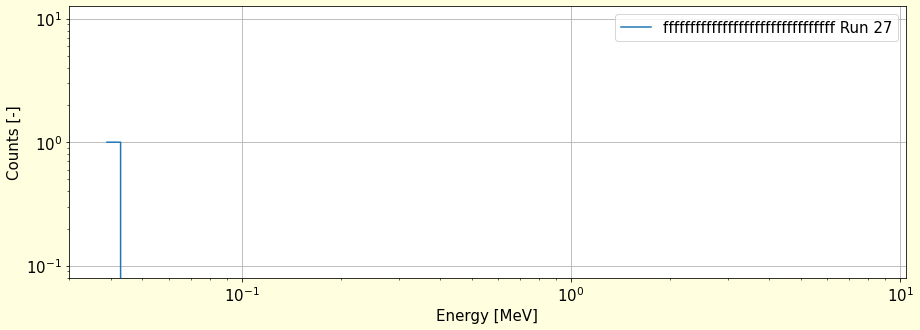

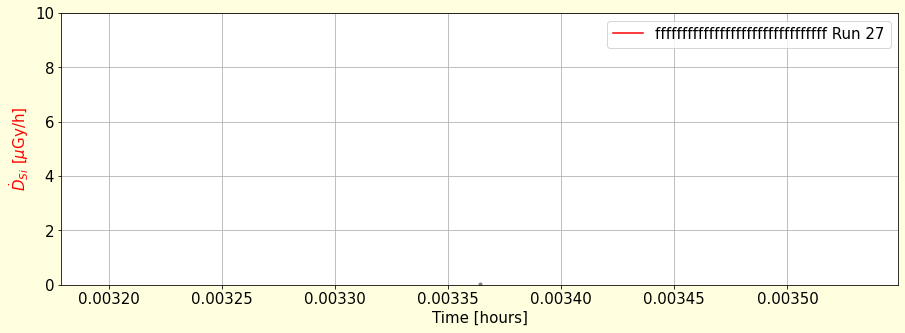

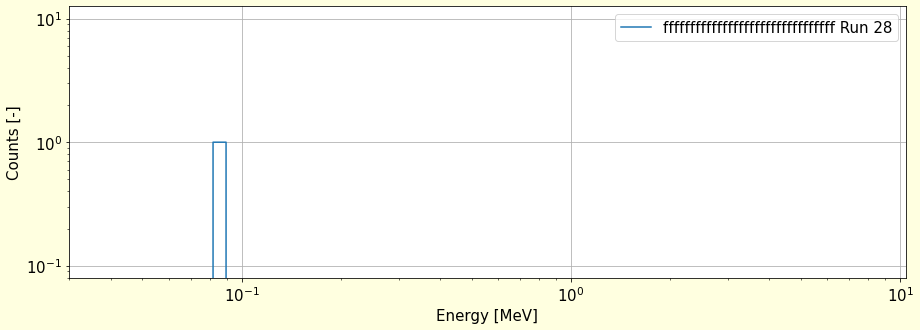

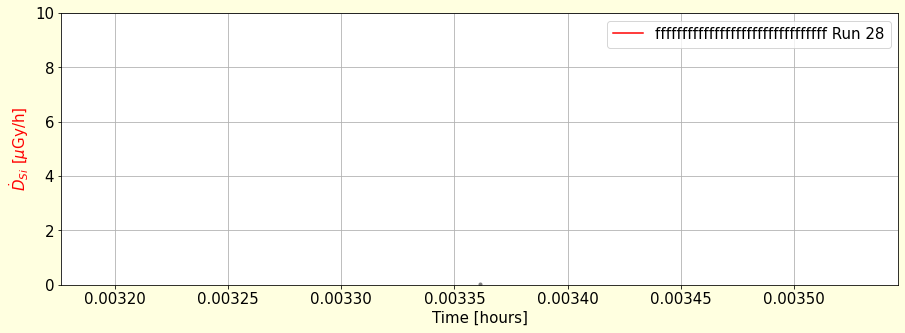

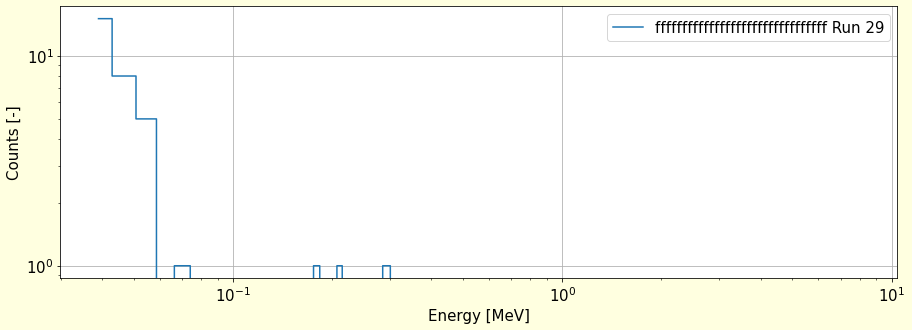

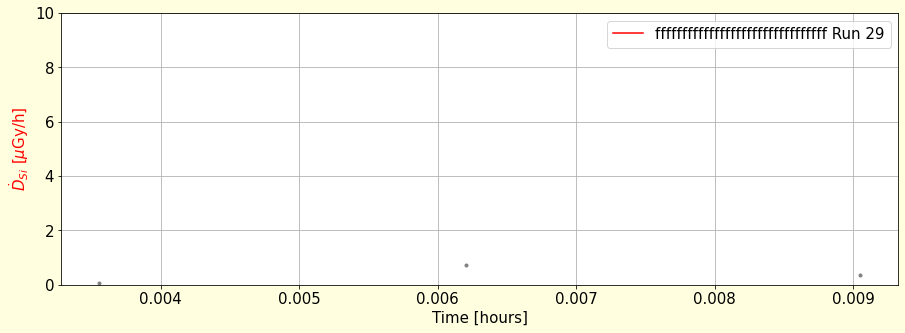

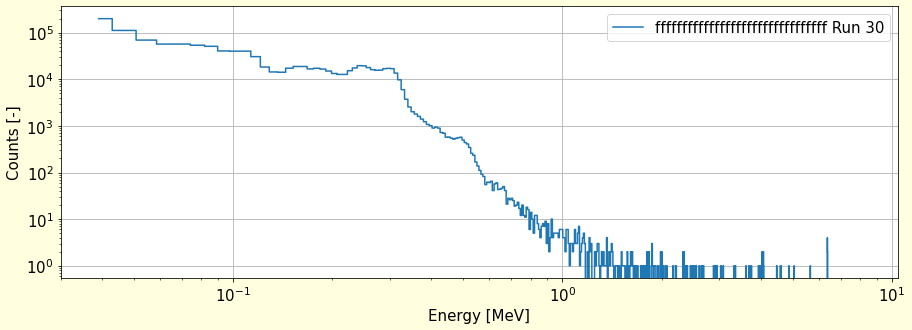

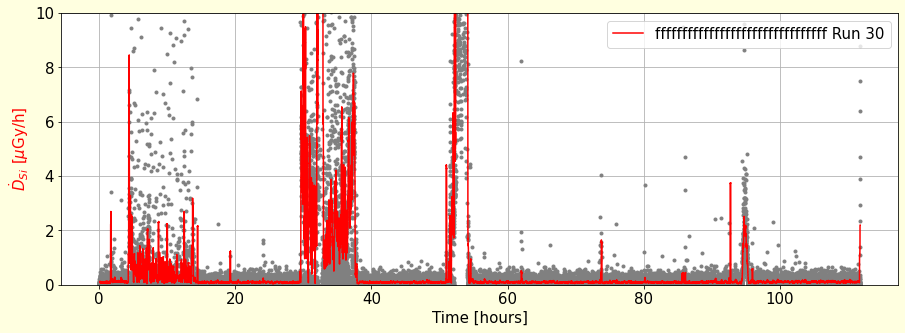

In [49]:
coef = np.array([0.,0.])
coef[1] = CH_WIDTH
coef[0] = CH_WIDTH*(FIRST_CHANNEL-ZERO_CHANNEL+1)
print(coef[0], coef[1])

for r in range(0,run):
    rc = df.loc[df['run']==r].copy()
    rc[2] = pd.to_numeric(rc[2], errors='coerce')

    plt.figure(figsize=(15,5), facecolor='lightyellow')
    matplotlib.rcParams.update({'font.size': 15})

    ener = rc.iloc[:,FIRST_CHANNEL:1028].sum()
    
    e = pd.DataFrame()
    e['1'] = ener
    e['i'] = ener.index
    e['x'] = (e['i'].astype(float)-FIRST_CHANNEL) * coef[1] + coef[0]

    plt.plot(e['x'], e['1'], drawstyle='steps-mid', label=sn+' Run '+str(r))

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Energy [MeV]')
    plt.ylabel('Counts [-]')
    plt.grid()

    plt.legend()
    plt.show()
    
    
    rc['ener'] = (np.asarray(rc.iloc[:,FIRST_CHANNEL:1028]) * np.asarray(e['x'])).sum(axis=1)    
    
    # size of the chip (20 mm · 10 mm), 
    # the thickness of the depletion layer (0.3 mm), 
    # and the density of silicon (2.33 g cm^3)
    # 0.1165e-3 kg
    rc['dsi'] = ((1e6 * (1.602e-19 * rc['ener'] * 1e6)/0.1165e-3)/10) * 3600 # in uGy/h

    rc['dsimean'] = rc['dsi'].rolling(30).mean()

    plt.figure(figsize=(15,5), facecolor='lightyellow')
    matplotlib.rcParams.update({'font.size': 15})
    plt.plot(rc[2]/3600,rc['dsi'], c='gray', linestyle='', marker='.')
    plt.plot(rc[2]/3600,rc['dsimean'],c='red', drawstyle='steps-mid', label=sn+' Run '+str(r))

    plt.ylim([0,10])

    plt.xlabel('Time [hours]')
    plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')
    plt.legend(loc=1)

    plt.grid()
    plt.show()


In [74]:
SELECTED_RUN = 0 # Measurement run (order of power on)
FROM = 0.0 # Start time in hour
TO = 0.5 # Stop time in hour

In [75]:
coef = np.array([0.,0.])
coef[1] = CH_WIDTH
coef[0] = CH_WIDTH*(FIRST_CHANNEL-ZERO_CHANNEL+1)
print('Min. sensitivity', coef[0], '[MeV], Channel width', coef[1], '[MeV]')

df[2] = pd.to_numeric(df[2], errors='coerce')
rc = df.loc[df['run']==SELECTED_RUN].loc[df[2]>=FROM*3600].loc[df[2]<=TO*3600].copy()

ener = rc.iloc[:,FIRST_CHANNEL:1028].sum()
e = pd.DataFrame()
e['1'] = ener
e['i'] = ener.index
e['x'] = (e['i'].astype(float)-FIRST_CHANNEL) * coef[1] + coef[0]
rc['ener'] = (np.asarray(rc.iloc[:,FIRST_CHANNEL:1028]) * np.asarray(e['x'])).sum(axis=1)    

# size of the chip (20 mm · 10 mm), 
# the thickness of the depletion layer (0.3 mm), 
# and the density of silicon (2.33 g cm^3)
# 0.1165e-3 kg
rc['dsi'] = ((1e6 * (1.602e-19 * rc['ener'] * 1e6)/0.1165e-3)/10) * 3600 # in uGy/h

print('S.N.',sn)
print('Run '+str(SELECTED_RUN),' From', FROM, '[hour] to', TO, '[hour]')
mean_doserate = rc.loc[rc[2]>=FROM*3600].loc[rc[2]<=TO*3600]['dsi'].mean()
print('Mean Dose Rate\033[1m',round(mean_doserate,2),'\033[0m[μGy/h]')
print('Dose in silicon\033[1m',round(mean_doserate * (TO-FROM),2),'±',3*round(rc.loc[rc[2]>=FROM*3600].loc[rc[2]<=TO*3600]['dsi'].sem(),2),'\033[0m[μGy]')

Min. sensitivity 0.039 [MeV], Channel width 0.0078 [MeV]
S.N. 1290c00806a20091d049a000a000003b
Run 0  From 0.0 [hour] to 0.5 [hour]
Mean Dose Rate 7.78 [μGy/h]
Dose in silicon 3.89 ± 0.78 [μGy]
